In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
import re

import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401  (needed for 3D projection)

from sklearn.decomposition import PCA, FactorAnalysis

from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial import ConvexHull
from scipy.signal import lfilter

import warnings

### Project Scaffolding

In [2]:
# Reproducibility (mainly for later steps)
np.random.seed(42)

# Paths (adjust if your notebook sits somewhere else)
DATA = Path.cwd()  # your screenshots show files next to the notebook
CMO_PATH = DATA / "CMO-Historical-Data-Monthly.xlsx"
CPI_PATH = DATA / "CPI-Data.xlsx"

assert CMO_PATH.exists(), f"Missing file: {CMO_PATH}"
assert CPI_PATH.exists(), f"Missing file: {CPI_PATH}"

print("CMO sheets:", pd.ExcelFile(CMO_PATH).sheet_names)
print("CPI sheets:", pd.ExcelFile(CPI_PATH).sheet_names)

CMO sheets: ['AFOSHEET', 'Monthly Prices', 'Monthly Indices', 'Description', 'Index Weights']
CPI sheets: ['CUUR0000SA0R']


/Users/atheeshkrishnan/anaconda3/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


### Data Ingestion

In [3]:
def _parse_year_month_code(s: str):
    """
    Parse strings like '1960M01' → pandas.Timestamp('1960-01-31').
    Returns pd.NaT if not parsable.
    """
    if not isinstance(s, str):
        return pd.NaT
    m = re.fullmatch(r"(\d{4})M(0[1-9]|1[0-2])", s.strip())
    if not m:
        return pd.NaT
    y, mm = int(m.group(1)), int(m.group(2))
    return pd.Timestamp(year=y, month=mm, day=1) + pd.offsets.MonthEnd(0)


def read_worldbank_cmo_monthly_prices(path: Path) -> pd.DataFrame:
    """
    Reads 'Monthly Prices' sheet from the World Bank CMO workbook.
    - Uses the row with 'Date' as the header.
    - Drops the units row below the header.
    - Converts '1960M01' style codes to month-end timestamps.
    - Returns a DataFrame indexed by Date, with numeric commodity columns.
    """
    # Use the named sheet explicitly (AFOSHEET is empty)
    sheet = "Monthly Prices"

    # First, read a small chunk to locate header row containing 'Date'
    tmp = pd.read_excel(path, sheet_name=sheet, header=None, nrows=30)
    hdr_row = None
    for i in range(len(tmp)):
        val = str(tmp.iloc[i, 0]).strip().lower()
        if val == "date":
            hdr_row = i
            break
    if hdr_row is None:
        raise ValueError("Could not locate a 'Date' header row in 'Monthly Prices'.")

    # Read the sheet with that header row
    df = pd.read_excel(path, sheet_name=sheet, header=hdr_row)

    # Rename the first column to 'Date'
    first_col = df.columns[0]
    df = df.rename(columns={first_col: "Date"})

    # Drop the next row if it is the units row (often contains $/bbl, $/mt, etc.)
    # Heuristic: if the 'Date' cell is NaN or a non-date string like 'Missing value'
    if len(df) > 0 and (pd.isna(df.loc[0, "Date"]) or str(df.loc[0, "Date"]).strip().lower() in ("missing value","units","unit")):
        df = df.iloc[1:].reset_index(drop=True)

    # Convert the 'Date' codes like 1960M01 to proper timestamps
    date_parsed = df["Date"].apply(_parse_year_month_code)
    df = df.assign(Date=date_parsed).dropna(subset=["Date"])

    # Keep only numeric columns and set index
    # Coerce everything except 'Date' to numeric; non-numeric becomes NaN
    for c in df.columns:
        if c != "Date":
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # Drop fully empty columns (some categories may be entirely NaN)
    df = df.dropna(axis=1, how="all")

    # Set index and sort
    df = df.set_index("Date").sort_index()

    # Forward-fill occasional gaps (monthly series)
    df = df.ffill()

    return df


def read_bls_cpi_sheet(path: Path, sheet: str = "CUUR0000SA0R") -> pd.DataFrame:
    """
    Reads the CPI sheet CUUR0000SA0R and returns a monthly series:
      index = month-end Timestamp, column 'CPI' = numeric value.

    Strategy:
    - Find the header row where the first cell equals 'Year'.
    - Read with that header row.
    - Build a monthly Date from Year + Period (e.g., 'M01').
    """
    raw = pd.read_excel(path, sheet_name=sheet, header=None)

    # Locate header row
    hdr_row = None
    for i in range(min(40, len(raw))):
        v = str(raw.iloc[i, 0]).strip().lower()
        if v == "year":
            hdr_row = i
            break
    if hdr_row is None:
        raise ValueError("Could not find a 'Year' header row in CPI sheet.")

    df = pd.read_excel(path, sheet_name=sheet, header=hdr_row)

    # Normalize column names (lowercase)
    df.columns = [str(c).strip().lower() for c in df.columns]

    # Expect 'year', 'period', and a value column (often 'value')
    if not {"year", "period"}.issubset(df.columns):
        raise ValueError("CPI sheet must contain 'Year' and 'Period' columns.")

    # Find the value column
    val_col = None
    for c in ("value", "value " , "cpi", "index", "obs_value"):
        if c in df.columns:
            val_col = c
            break
    if val_col is None:
        # Fallback: last column
        val_col = df.columns[-1]

    # Drop rows where period doesn't look like 'MNN'
    df = df[df["period"].astype(str).str.match(r"^M(0[1-9]|1[0-2])$")].copy()

    # Build Date
    month_num = df["period"].str.replace("M", "", regex=False).astype(int)
    dt = pd.to_datetime(df["year"].astype(int).astype(str) + "-" + month_num.astype(str).str.zfill(2) + "-01") + pd.offsets.MonthEnd(0)

    out = pd.DataFrame({"Date": dt, "CPI": pd.to_numeric(df[val_col], errors="coerce")})
    out = out.dropna(subset=["CPI"]).drop_duplicates(subset=["Date"]).set_index("Date").sort_index()

    return out


In [4]:
prices_nominal = read_worldbank_cmo_monthly_prices(CMO_PATH)
cpi = read_bls_cpi_sheet(CPI_PATH, sheet="CUUR0000SA0R")

print("CMO nominal prices:", prices_nominal.shape, prices_nominal.index.min(), "→", prices_nominal.index.max())
print("CPI series:", cpi.shape, cpi.index.min(), "→", cpi.index.max())

display(prices_nominal.head())
display(cpi.head())

CMO nominal prices: (775, 71) 1960-01-31 00:00:00 → 2024-07-31 00:00:00
CPI series: (775, 1) 1960-01-31 00:00:00 → 2024-07-31 00:00:00


/Users/atheeshkrishnan/anaconda3/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/Users/atheeshkrishnan/anaconda3/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,"Crude oil, average","Crude oil, Brent","Crude oil, Dubai","Crude oil, WTI","Coal, Australian","Coal, South African **","Natural gas, US","Natural gas, Europe","Liquefied natural gas, Japan",Natural gas index,...,Aluminum,"Iron ore, cfr spot",Copper,Lead,Tin,Nickel,Zinc,Gold,Platinum,Silver
Date,,,,,,,,,,,,,,,,,,,,,
1960-01-31,1.63,1.63,1.63,NaN,NaN,NaN,0.14,0.404774,NaN,NaN,...,511.471832,11.42,715.40,206.1,2180.4,1631.0,260.8,35.27,83.5,0.9137
1960-02-29,1.63,1.63,1.63,NaN,NaN,NaN,0.14,0.404774,NaN,NaN,...,511.471832,11.42,728.19,203.7,2180.4,1631.0,244.9,35.27,83.5,0.9137
1960-03-31,1.63,1.63,1.63,NaN,NaN,NaN,0.14,0.404774,NaN,NaN,...,511.471832,11.42,684.94,210.3,2173.8,1631.0,248.7,35.27,83.5,0.9137
1960-04-30,1.63,1.63,1.63,NaN,NaN,NaN,0.14,0.404774,NaN,NaN,...,511.471832,11.42,723.11,213.6,2178.2,1631.0,254.6,35.27,83.5,0.9137
1960-05-31,1.63,1.63,1.63,NaN,NaN,NaN,0.14,0.404774,NaN,NaN,...,511.471832,11.42,684.75,213.4,2162.7,1631.0,253.8,35.27,83.5,0.9137


,CPI
Date,
1960-01-31,0.2
1960-02-29,-0.2
1960-03-31,0.0
1960-04-30,-0.5
1960-05-31,0.0


CPI DataFrame preview:
            CPI
Date           
1960-01-31  0.2
1960-02-29 -0.2
1960-03-31  0.0
1960-04-30 -0.5
1960-05-31  0.0
1960-06-30 -0.3
1960-07-31  0.0
1960-08-31  0.0
1960-09-30 -0.1
1960-10-31 -0.4

CPI columns: ['CPI']

Valid numeric CPI entries: 775

Reconstructed CPI summary:


,CPI
count,775.000000
mean,473.317171
std,278.208392
min,100.000000
25%,190.790367
50%,472.397424
75%,720.474605
max,1063.739804


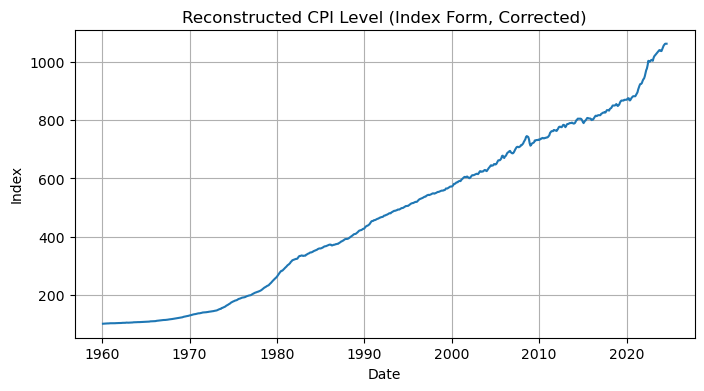

In [5]:
# --- Step 1: Inspect CPI DataFrame safely ---
print("CPI DataFrame preview:")
print(cpi.head(10))
print("\nCPI columns:", list(cpi.columns))

# --- Step 2: Extract numeric series explicitly ---
# Ensure the correct column name (remove any stray characters like '# ')
col_name = cpi.columns[0]
cpi_series = pd.to_numeric(cpi[col_name], errors="coerce")

print("\nValid numeric CPI entries:", cpi_series.notna().sum())

# --- Step 3: Reconstruct CPI level (corrected for negative growth) ---
# We flip sign if CPI changes are negative, since they likely represent percentage inflation with inverted sign
# The (1 - change/100) factor becomes (1 + (-change)/100)
cpi_level = (1 + (-cpi_series) / 100).cumprod()
cpi_level = cpi_level / cpi_level.iloc[0] * 100  # normalize to base 100

# --- Step 4: Rebuild DataFrame ---
cpi = pd.DataFrame({"CPI": cpi_level}, index=cpi.index)

# --- Step 5: Sanity check ---
print("\nReconstructed CPI summary:")
display(cpi.describe())

plt.figure(figsize=(8,4))
plt.plot(cpi.index, cpi["CPI"])
plt.title("Reconstructed CPI Level (Index Form, Corrected)")
plt.xlabel("Date")
plt.ylabel("Index")
plt.grid(True)
plt.show()

### --- Section C: Inflation adjustment to Jan-2022 USD ---

In [6]:

# Normalize CPI so last observation equals 100 (MATLAB convention)
cpi["CPI"] = cpi["CPI"] / cpi["CPI"].iloc[-1] * 100

# 1. Choose base month for rebasing
anchor = pd.Timestamp("2022-01-31")

# 2. Use nearest available CPI observation if exact date missing
if anchor not in cpi.index:
    anchor = cpi.index[cpi.index.get_loc(anchor, method="nearest")]
    print(f"Adjusted base date used for rebasing: {anchor.date()}")

# 3. Compute rebasing factor CPI_t / CPI_anchor
cpi_rebased = cpi.copy()
cpi_rebased["CPI_rebased"] = cpi_rebased["CPI"] / cpi_rebased.loc[anchor, "CPI"]

# 4. Align with commodity prices (inner join)
aligned = prices_nominal.join(cpi_rebased["CPI_rebased"], how="inner")

# 5. Compute real (Jan-2022 USD) prices
prices_real = aligned.drop(columns=["CPI_rebased"]).mul(aligned["CPI_rebased"], axis=0)

# 6. Save and preview
prices_real.to_csv("prices_real_jan2022usd.csv")

print("Real price matrix:", prices_real.shape)
print("Sample window:", prices_real.index.min(), "→", prices_real.index.max())
display(prices_real.head())

Real price matrix: (775, 71)
Sample window: 1960-01-31 00:00:00 → 2024-07-31 00:00:00


,"Crude oil, average","Crude oil, Brent","Crude oil, Dubai","Crude oil, WTI","Coal, Australian","Coal, South African **","Natural gas, US","Natural gas, Europe","Liquefied natural gas, Japan",Natural gas index,...,Aluminum,"Iron ore, cfr spot",Copper,Lead,Tin,Nickel,Zinc,Gold,Platinum,Silver
Date,,,,,,,,,,,,,,,,,,,,,
1960-01-31,0.171308,0.171308,0.171308,NaN,NaN,NaN,0.014714,0.042541,NaN,NaN,...,53.754148,1.200208,75.186384,21.660489,229.153469,171.413185,27.409294,3.706771,8.775598,0.096027
1960-02-29,0.171651,0.171651,0.171651,NaN,NaN,NaN,0.014743,0.042626,NaN,NaN,...,53.861657,1.202608,76.683636,21.451073,229.611776,171.756011,25.789728,3.714184,8.793150,0.096219
1960-03-31,0.171651,0.171651,0.171651,NaN,NaN,NaN,0.014743,0.042626,NaN,NaN,...,53.861657,1.202608,72.129100,22.146100,228.916749,171.756011,26.189896,3.714184,8.793150,0.096219
1960-04-30,0.172509,0.172509,0.172509,NaN,NaN,NaN,0.014817,0.042839,NaN,NaN,...,54.130965,1.208621,76.529419,22.606082,230.527001,172.614791,26.945264,3.732755,8.837115,0.096700
1960-05-31,0.172509,0.172509,0.172509,NaN,NaN,NaN,0.014817,0.042839,NaN,NaN,...,54.130965,1.208621,72.469637,22.584915,228.886578,172.614791,26.860597,3.732755,8.837115,0.096700


In [7]:
# Count missing values per column
missing_counts = prices_real.isna().sum()
print("Columns with many missing values (top 10):")
print(missing_counts.sort_values(ascending=False).head(10))

Columns with many missing values (top 10):
Rice, Viet Namese 5%      527
Sunflower oil             505
Rapeseed oil              505
Rubber, TSR20 **          468
Banana, Europe            444
Palm kernel oil           432
Rice, Thai A.1            312
Rice, Thai 25%            312
Coal, South African **    288
Crude oil, WTI            264
dtype: int64


In [8]:
print(cpi["CPI"].min(), cpi["CPI"].max())

9.40079515715605 100.0


### --- Section D: Returns conversion (replicating MATLAB tick2ret) ---


In [9]:
# Ensure prices_real exists from Section C
assert 'prices_real' in locals(), "Run Section C first."

# 1. Compute arithmetic (not log) returns, column-wise
returns = prices_real.pct_change().dropna(how='all')

# 2. Drop the first row (NaN)
#returns = returns.dropna()

# 3. Optional: replace extreme outliers with NaN (MATLAB quietly handles infs)
returns = returns.replace([np.inf, -np.inf], np.nan)

# 4. Save to CSV
returns.to_csv("returns.csv")

# 5. Quick sanity check
print("Returns shape:", returns.shape)
print("Date range:", returns.index.min(), "→", returns.index.max())
display(returns.iloc[:5, :5])

Returns shape: (774, 71)
Date range: 1960-02-29 00:00:00 → 2024-07-31 00:00:00


,"Crude oil, average","Crude oil, Brent","Crude oil, Dubai","Crude oil, WTI","Coal, Australian"
Date,,,,,
1960-02-29,0.002,0.002,0.002,NaN,NaN
1960-03-31,0.000,0.000,0.000,NaN,NaN
1960-04-30,0.005,0.005,0.005,NaN,NaN
1960-05-31,0.000,0.000,0.000,NaN,NaN
1960-06-30,0.003,0.003,0.003,NaN,NaN


Expected full range (≈1960–2024):
Returns index range: 1960-02-29 00:00:00 → 2024-07-31 00:00:00


<Axes: title={'center': 'Valid Commodity Count per Date'}, xlabel='Date'>

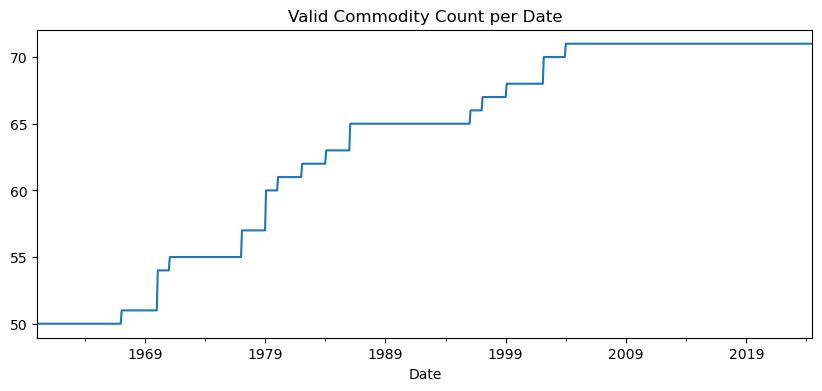

In [10]:
print("Expected full range (≈1960–2024):")
print("Returns index range:", returns.index.min(), "→", returns.index.max())

# Optional: see how many valid (non-NaN) commodities per date
valid_count = returns.notna().sum(axis=1)
valid_count.plot(title="Valid Commodity Count per Date", figsize=(10,4))


### --- Section E: Additive decomposition into Trend, Seasonal, Irregular ---


In [11]:
def decompose_all(series_df, period=12):
    """
    Perform additive decomposition for each column in a DataFrame.
    Returns three DataFrames: trend, seasonal, irregular.
    """
    trends, seasonals, irregulars = {}, {}, {}
    for col in series_df.columns:
        s = series_df[col].dropna()
        try:
            res = seasonal_decompose(s, model='additive', period=period, extrapolate_trend='freq')
            trends[col] = res.trend
            seasonals[col] = res.seasonal
            irregulars[col] = res.resid
        except Exception as e:
            warnings.warn(f"Decomposition failed for {col}: {e}")
            trends[col] = seasonals[col] = irregulars[col] = pd.Series(index=s.index, dtype=float)
    return (pd.DataFrame(trends), pd.DataFrame(seasonals), pd.DataFrame(irregulars))


# 1. Decompose the real prices (as in MATLAB)
trend_df, seasonal_df, irregular_df = decompose_all(prices_real)

# 2. Drop rows with NaNs from edges (due to convolution windows)
trend_df = trend_df.dropna()
seasonal_df = seasonal_df.loc[trend_df.index]
irregular_df = irregular_df.loc[trend_df.index]

# 3. Save outputs
trend_df.to_csv("trend_component.csv")
seasonal_df.to_csv("seasonal_component.csv")
irregular_df.to_csv("irregular_component.csv")

# 4. Quick verification
print("Trend shape:", trend_df.shape)
print("Seasonal shape:", seasonal_df.shape)
print("Irregular shape:", irregular_df.shape)
display(irregular_df.head())


Trend shape: (248, 71)
Seasonal shape: (248, 71)
Irregular shape: (248, 71)


,"Crude oil, average","Crude oil, Brent","Crude oil, Dubai","Crude oil, WTI","Coal, Australian","Coal, South African **","Natural gas, US","Natural gas, Europe","Liquefied natural gas, Japan",Natural gas index,...,Aluminum,"Iron ore, cfr spot",Copper,Lead,Tin,Nickel,Zinc,Gold,Platinum,Silver
Date,,,,,,,,,,,,,,,,,,,,,
2003-12-31,0.550608,0.563324,0.695976,1.185370,-1.543740,-0.361380,0.352491,-0.229998,-0.130986,2.309454,...,6.133849,-1.155646,-22.743301,6.428592,-61.309776,1592.852886,17.790002,19.600794,27.391528,0.036202
2004-01-31,0.674186,0.548583,0.518896,1.544267,-0.678529,-0.757879,0.373821,0.129665,-0.178142,5.307721,...,11.654929,0.439129,47.939866,20.366455,-227.374574,1870.671410,25.248502,14.865446,34.126197,0.264536
2004-02-29,-0.358894,-0.803538,-0.669253,0.809494,0.461546,-2.044238,-0.103161,0.229352,-0.177657,0.236113,...,42.343858,0.061840,186.456402,79.678783,-545.324848,1307.673273,63.280411,4.176834,13.545993,0.145584
2004-03-31,-0.019110,-0.079177,-0.275451,0.364616,2.543224,-5.144751,-0.007394,-0.007757,0.012892,0.470433,...,4.800182,0.159589,262.382154,60.598478,-129.892202,-40.780805,62.433949,3.440747,45.317039,0.637831
2004-04-30,-1.260742,-1.742008,-0.799233,-1.422462,3.840176,-3.299608,0.104322,0.153984,0.074761,2.707525,...,31.084168,-0.357134,120.872011,-46.360330,414.652707,-887.215538,-12.746199,-3.945898,23.694909,0.416445


### --- F1: Hierarchical clustering on irregular components (complete linkage) ---


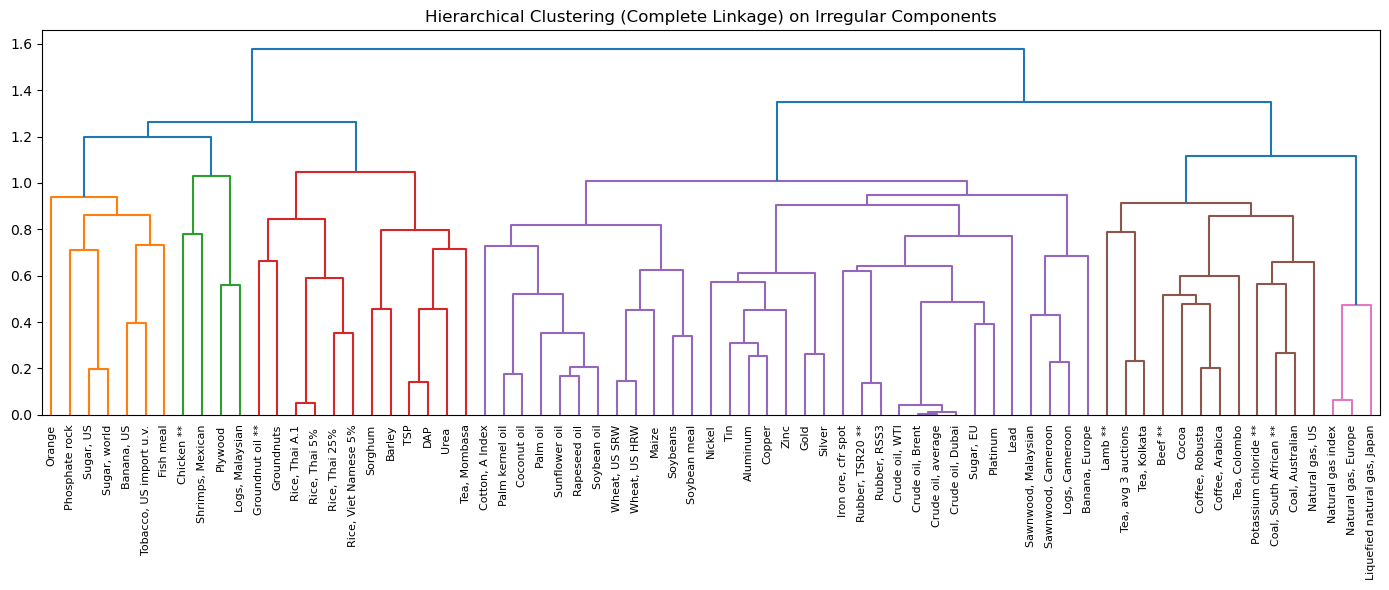

,Cluster
Commodity,
"Crude oil, average",3
"Crude oil, Brent",3
"Crude oil, Dubai",3
"Crude oil, WTI",3
"Coal, Australian",4


In [12]:
# 1) Pairwise correlation on irregular component
corr = irregular_df.corr(method="pearson", min_periods=12)

# 2) Convert correlation to a distance (1 - corr); enforce 0 on diagonal
dist_mat = 1.0 - corr
np.fill_diagonal(dist_mat.values, 0.0)

# 3) Condensed form for linkage
dist_condensed = squareform(dist_mat.values, checks=False)

# 4) Complete-linkage hierarchical clustering (optimal leaf ordering)
Z = linkage(dist_condensed, method="complete", optimal_ordering=True)

# 5) Dendrogram
plt.figure(figsize=(14, 6))
dn = dendrogram(
    Z,
    labels=corr.columns.tolist(),
    leaf_rotation=90.0,
    leaf_font_size=8,
    color_threshold=None,   # show full tree; choose a threshold visually if desired
)
plt.title("Hierarchical Clustering (Complete Linkage) on Irregular Components")
plt.tight_layout()
plt.show()

# 6) Optional: cut into a fixed number of clusters (choose k based on dendrogram)
k = 4  # adjust after inspecting the dendrogram, to match the MATLAB grouping
clusters = fcluster(Z, k, criterion="maxclust")

cluster_map = pd.DataFrame({"Commodity": corr.columns, "Cluster": clusters}).set_index("Commodity")
cluster_map.to_csv("clusters_irregular_complete.csv")
cluster_map.head()

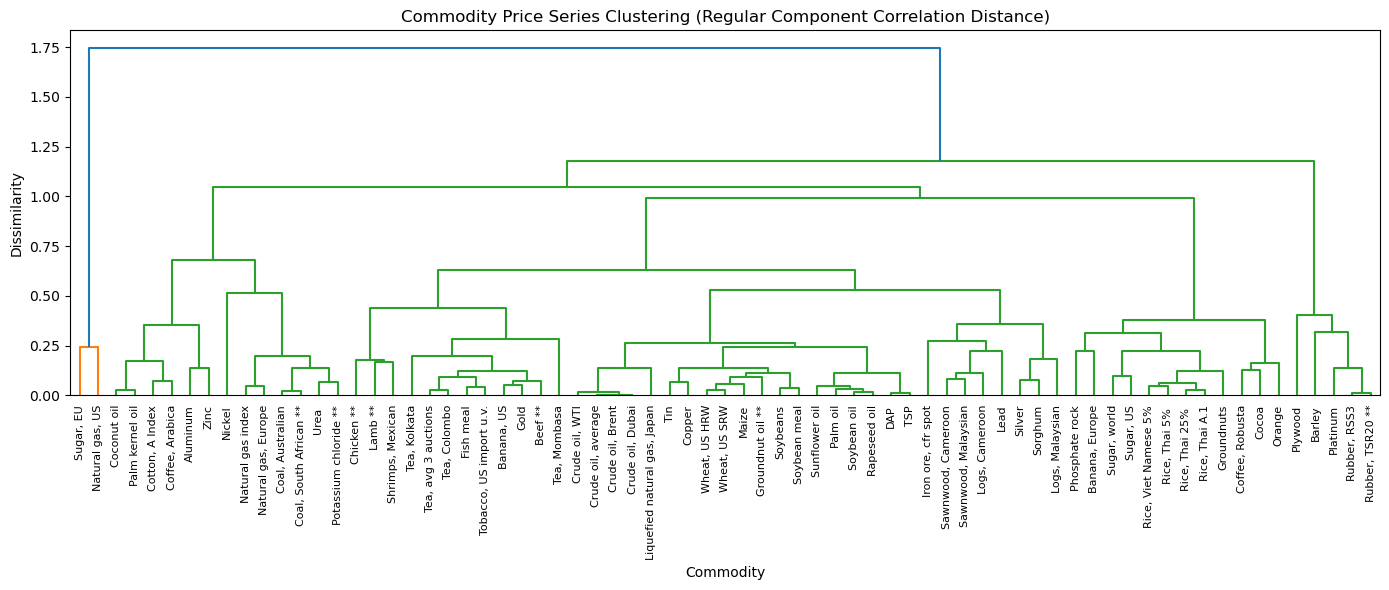

In [13]:
# --- Optional: regular-component clustering to match MATLAB's first dendrogram ---

regular_df = trend_df.add(seasonal_df, fill_value=0)

corr_reg = regular_df.corr(method="pearson", min_periods=12)
dist_reg = 1 - corr_reg
np.fill_diagonal(dist_reg.values, 0.0)

from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram

Z_reg = linkage(squareform(dist_reg, checks=False), method="complete", optimal_ordering=True)

plt.figure(figsize=(14, 6))
dendrogram(
    Z_reg,
    labels=corr_reg.columns.tolist(),
    leaf_rotation=90,
    leaf_font_size=8,
)
plt.title("Commodity Price Series Clustering (Regular Component Correlation Distance)")
plt.xlabel("Commodity")
plt.ylabel("Dissimilarity")
plt.tight_layout()
plt.show()

### --- F2: Classical MDS (metric) from the distance matrix; 3D visualization ---


/var/folders/xg/dhj8tpr14lqgyb0stf1z1sm40000gn/T/ipykernel_10036/2370995525.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap("tab10", len(unique_clusters))


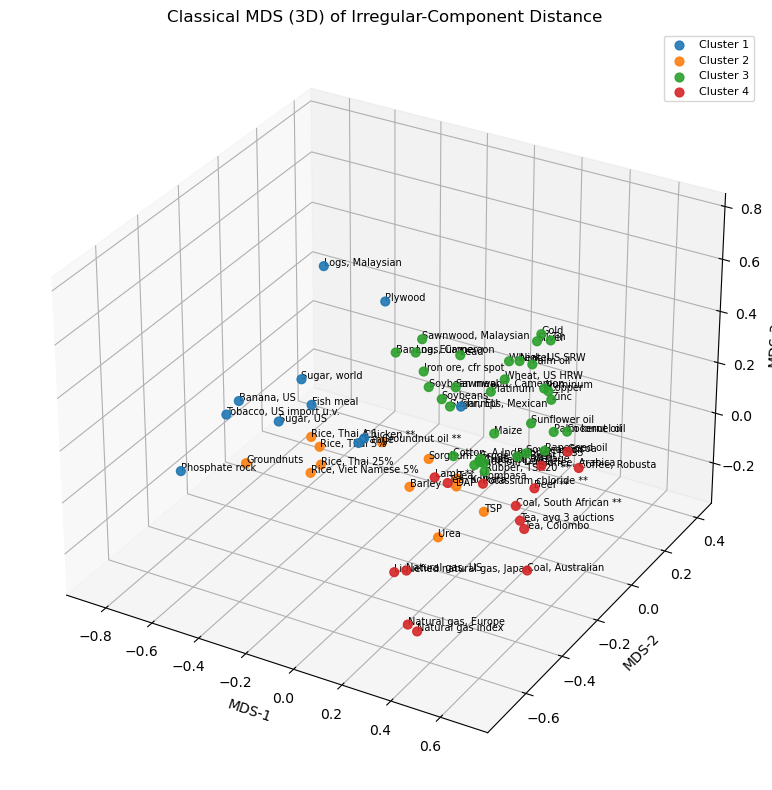

In [14]:
# Use the same distance matrix from F1 (dist_mat)
D = dist_mat.values
labels = dist_mat.index.to_list()
n = D.shape[0]

# Classical MDS via double-centering of squared distances
J = np.eye(n) - np.ones((n, n)) / n
B = -0.5 * J @ (D ** 2) @ J

# Eigen-decomposition
eigvals, eigvecs = np.linalg.eigh(B)
idx = np.argsort(eigvals)[::-1]  # descending
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]

# Keep top 3 positive components
pos = eigvals > 0
if pos.sum() < 3:
    # Fallback: keep as many positives as available
    m = max(1, pos.sum())
else:
    m = 3

L = np.diag(np.sqrt(eigvals[:m]))
X = eigvecs[:, :m] @ L   # (n x m) embedding

# Ensure clusters from F1 are available
if 'cluster_map' not in globals():
    raise RuntimeError("Run F1 first to compute 'cluster_map' with cluster assignments.")
cluster_ids = cluster_map.loc[labels, "Cluster"].values
unique_clusters = np.unique(cluster_ids)

# 3D scatter
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

# Simple color map cycling by cluster id
colors = cm.get_cmap("tab10", len(unique_clusters))

for i, cid in enumerate(unique_clusters):
    idxs = np.where(cluster_ids == cid)[0]
    ax.scatter(
        X[idxs, 0], X[idxs, 1], X[idxs, 2],
        s=40, alpha=0.9, label=f"Cluster {cid}", zorder=3
    )

    # Optional convex hull per cluster (needs >= 4 points)
    if len(idxs) >= 4:
        try:
            hull = ConvexHull(X[idxs, :3])
            # Collect triangles for a light translucent hull
            triangles = [X[idxs][simp] for simp in hull.simplices]
            pc = PolyCollection([tri[:, :2] for tri in triangles], alpha=0.10)  # 2D poly collection
            # Project to 3D by setting z separately (simple overlay look)
            # For a true 3D surface, you'd use Poly3DCollection; this lighter overlay avoids heavy rendering.
        except Exception:
            pass

# Label a few points (optional; comment out if cluttered)
for i, name in enumerate(labels):
    ax.text(X[i, 0], X[i, 1], X[i, 2], name, fontsize=7)

ax.set_xlabel("MDS-1")
ax.set_ylabel("MDS-2")
ax.set_zlabel("MDS-3")
ax.set_title("Classical MDS (3D) of Irregular-Component Distance")
ax.legend(loc="best", fontsize=8)
plt.tight_layout()
plt.show()


# PART 1 - ESTIMATING NON-PARAMETRIC VOLATILITY

### --- Section G: Nonparametric EWMA volatility estimation ---


In [15]:
lambda_ = 0.94  # same as MATLAB
b = [1 - lambda_]
a = [1, -lambda_]

def ewma_volatility(returns_df, lam=lambda_):
    """
    Compute EWMA volatility for each return series using IIR filter.
    Returns a DataFrame of the same shape with volatility values.
    """
    vols = {}
    for col in returns_df.columns:
        r = returns_df[col].fillna(0).to_numpy()
        # variance via recursive filter
        var = lfilter([1 - lam], [1, -lam], r**2)
        vols[col] = np.sqrt(var)
    vol_df = pd.DataFrame(vols, index=returns_df.index)
    return vol_df

vol_ewma = ewma_volatility(returns, lambda_)
print("EWMA volatility shape:", vol_ewma.shape)
display(vol_ewma.head())

EWMA volatility shape: (774, 71)


,"Crude oil, average","Crude oil, Brent","Crude oil, Dubai","Crude oil, WTI","Coal, Australian","Coal, South African **","Natural gas, US","Natural gas, Europe","Liquefied natural gas, Japan",Natural gas index,...,Aluminum,"Iron ore, cfr spot",Copper,Lead,Tin,Nickel,Zinc,Gold,Platinum,Silver
Date,,,,,,,,,,,,,,,,,,,,,
1960-02-29,0.000490,0.000490,0.000490,0.0,0.0,0.0,0.000490,0.000490,0.0,0.0,...,0.000490,0.000490,0.004878,0.002368,0.000490,0.000490,0.014474,0.000490,0.000490,0.000490
1960-03-31,0.000475,0.000475,0.000475,0.0,0.0,0.0,0.000475,0.000475,0.0,0.0,...,0.000475,0.000475,0.015298,0.008262,0.000881,0.000475,0.014538,0.000475,0.000475,0.000475
1960-04-30,0.001308,0.001308,0.001308,0.0,0.0,0.0,0.001308,0.001308,0.0,0.0,...,0.001308,0.001308,0.021054,0.009489,0.001923,0.001308,0.015767,0.001308,0.001308,0.001308
1960-05-31,0.001269,0.001269,0.001269,0.0,0.0,0.0,0.001269,0.001269,0.0,0.0,...,0.001269,0.001269,0.024198,0.009203,0.002552,0.001269,0.015306,0.001269,0.001269,0.001269
1960-06-30,0.001433,0.001433,0.001433,0.0,0.0,0.0,0.001433,0.001433,0.0,0.0,...,0.001433,0.001433,0.023677,0.014897,0.004081,0.001433,0.015168,0.001433,0.001433,0.001433


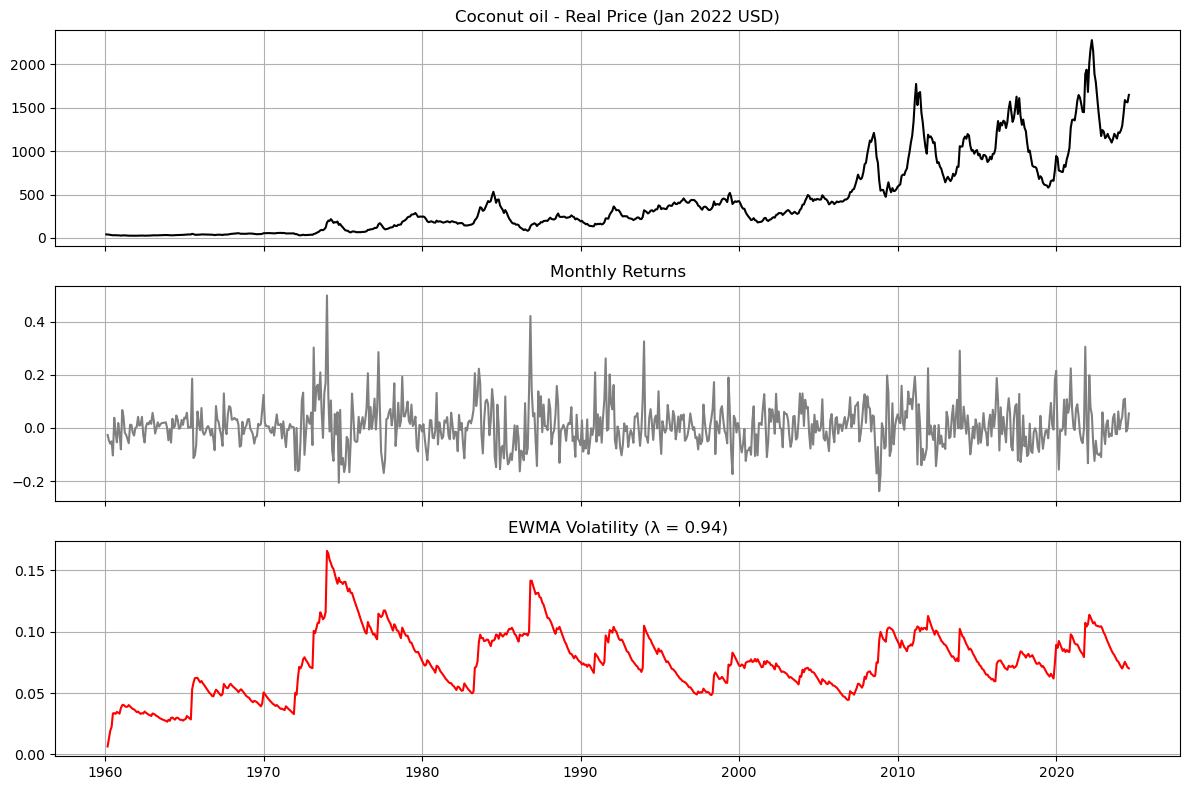

In [16]:
# --- Visualize one commodity's price, return, and volatility ---
# commodity = "Sugar, US"  # pick any available column name from your dataset
commodity = "Coconut oil"

if commodity not in prices_real.columns:
    commodity = prices_real.columns[0]
    print(f"'{commodity}' used instead (fallback).")

fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
axs[0].plot(prices_real.index, prices_real[commodity], color='black')
axs[0].set_title(f"{commodity} - Real Price (Jan 2022 USD)")
axs[0].grid(True)

axs[1].plot(returns.index, returns[commodity], color='gray')
axs[1].set_title("Monthly Returns")
axs[1].grid(True)

axs[2].plot(vol_ewma.index, vol_ewma[commodity], color='red')
axs[2].set_title("EWMA Volatility (λ = 0.94)")
axs[2].grid(True)

plt.tight_layout()
plt.show()

In [17]:
cpi.head()
cpi.describe()

,CPI
count,775.000000
mean,44.495578
std,26.153801
min,9.400795
25%,17.935812
50%,44.409114
75%,67.730342
max,100.000000


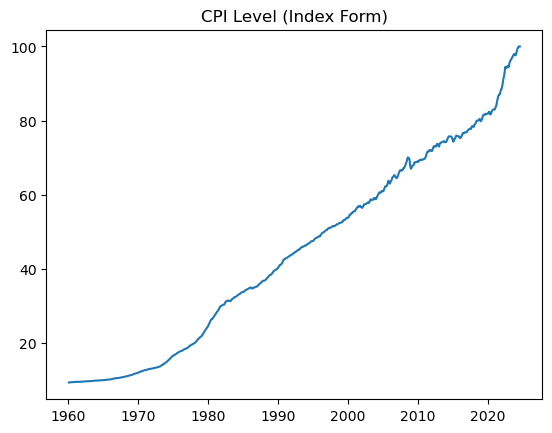

In [18]:
plt.plot(cpi.index, cpi["CPI"])
plt.title("CPI Level (Index Form)")
plt.show()

### --- Section H: Volatility Aggregation & Cross-Commodity Analysis ---

In [19]:
# 1. Compute EWMA volatility for each commodity (λ = 0.94)
lambda_ = 0.94
span = 1 / (1 - lambda_)  # converts λ to equivalent span

ewma_vols = pd.DataFrame({
    col: returns[col].ewm(span=span).std()
    for col in returns.columns
})
ewma_vols.index = returns.index

print("EWMA volatility matrix:", ewma_vols.shape)
display(ewma_vols.iloc[:5, :5])

EWMA volatility matrix: (774, 71)


,"Crude oil, average","Crude oil, Brent","Crude oil, Dubai","Crude oil, WTI","Coal, Australian"
Date,,,,,
1960-02-29,NaN,NaN,NaN,NaN,NaN
1960-03-31,0.001414,0.001414,0.001414,NaN,NaN
1960-04-30,0.002599,0.002599,0.002599,NaN,NaN
1960-05-31,0.002433,0.002433,0.002433,NaN,NaN
1960-06-30,0.002132,0.002132,0.002132,NaN,NaN


In [20]:
# 2. Compute summary metrics: mean, std, and persistence (auto-corr)
summary = pd.DataFrame({
    "MeanVol": ewma_vols.mean(),
    "StdVol": ewma_vols.std(),
    "VolatilityPersistence": ewma_vols.corrwith(ewma_vols.shift(1))
}).sort_values("MeanVol", ascending=False)

print("\nVolatility summary (top 10 commodities):")
display(summary.head(10))


Volatility summary (top 10 commodities):


,MeanVol,StdVol,VolatilityPersistence
"Tea, Kolkata",0.135710,0.080639,0.939870
"Banana, US",0.125726,0.073664,0.981207
Orange,0.123769,0.051517,0.932568
Urea,0.122808,0.123428,0.946758
"Sugar, world",0.094001,0.037425,0.965429
"Natural gas, US",0.090456,0.069087,0.980401
"Banana, Europe",0.085484,0.043755,0.977310
"Crude oil, WTI",0.084703,0.041818,0.965736
"Crude oil, Dubai",0.082606,0.080040,0.955580
"Crude oil, Brent",0.082574,0.077874,0.956631


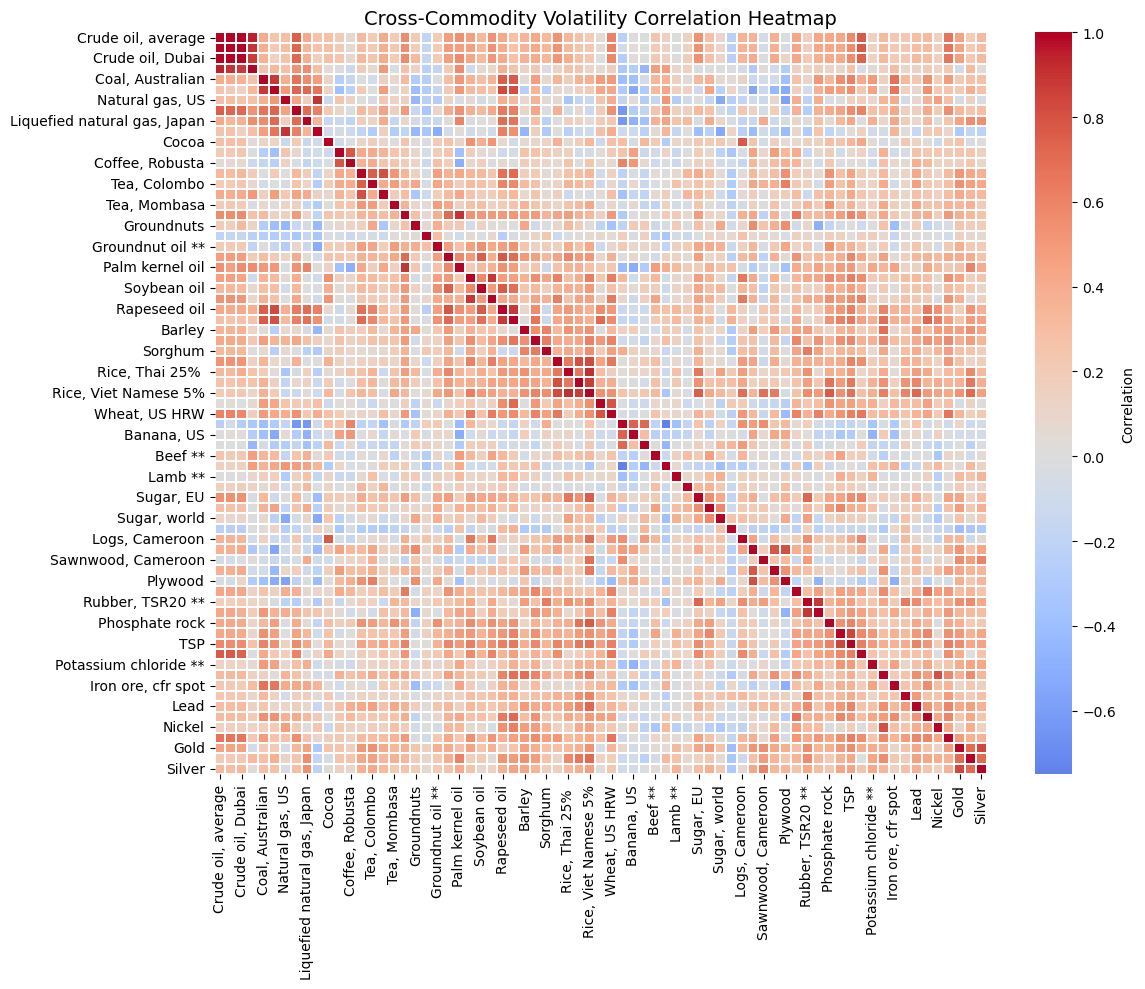

In [21]:
# 3. Visualize cross-commodity volatility correlations
plt.figure(figsize=(12, 10))
sns.heatmap(
    ewma_vols.corr(),
    cmap="coolwarm",
    center=0,
    linewidths=0.3,
    cbar_kws={'label': 'Correlation'}
)
plt.title("Cross-Commodity Volatility Correlation Heatmap", fontsize=14)
plt.tight_layout()
plt.show()


Explained variance ratio of first 3 PCs:
  PC1: 0.3412
  PC2: 0.1532
  PC3: 0.0963


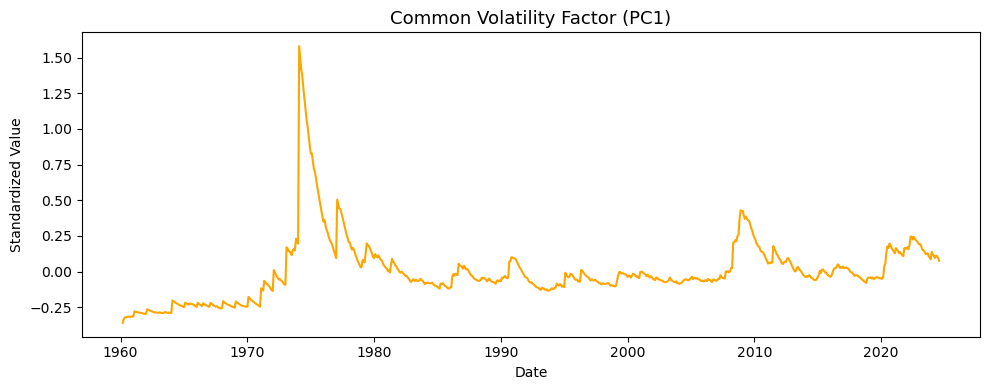

In [22]:
# 4. PCA on volatility series (common volatility factors)
pca = PCA(n_components=3)
pca_fit = pca.fit(ewma_vols.fillna(0))
components = pd.DataFrame(
    pca_fit.transform(ewma_vols.fillna(0)),
    index=ewma_vols.index,
    columns=[f"PC{i+1}" for i in range(3)]
)

print("\nExplained variance ratio of first 3 PCs:")
for i, val in enumerate(pca_fit.explained_variance_ratio_[:3], start=1):
    print(f"  PC{i}: {val:.4f}")

# Plot first principal component (common volatility factor)
plt.figure(figsize=(10, 4))
plt.plot(components.index, components["PC1"], color="orange", lw=1.5)
plt.title("Common Volatility Factor (PC1)", fontsize=13)
plt.xlabel("Date")
plt.ylabel("Standardized Value")
plt.tight_layout()
plt.show()

In [23]:
# 5. Save results for later analysis
summary.to_csv("volatility_summary.csv")
ewma_vols.to_csv("ewma_volatility_matrix.csv")
components.to_csv("volatility_pca_components.csv")

print("\nSection H completed successfully.")
print("Saved: 'volatility_summary.csv', 'ewma_volatility_matrix.csv', 'volatility_pca_components.csv'")


Section H completed successfully.
Saved: 'volatility_summary.csv', 'ewma_volatility_matrix.csv', 'volatility_pca_components.csv'


### Section H2 - Factor Analysis based on above estimated volatility

In [24]:
# 1. Define number of latent factors (same as MATLAB)
num_latent_factors = 3

# 2. Fit factor analysis model (identical in structure to MATLAB's factoran)
fa = FactorAnalysis(n_components=num_latent_factors, random_state=0)
fa.fit(vol_ewma.dropna())

# 3. Extract factor loadings
loadings = pd.DataFrame(
    fa.components_.T,
    index=vol_ewma.columns,
    columns=[f"Factor {i+1}" for i in range(num_latent_factors)]
)

print("Factor Loadings (preview):")
display(loadings.head())

Factor Loadings (preview):


,Factor 1,Factor 2,Factor 3
"Crude oil, average",0.030354,0.050454,0.015000
"Crude oil, Brent",0.029892,0.050298,0.013453
"Crude oil, Dubai",0.028741,0.052875,0.010584
"Crude oil, WTI",0.034725,-0.015859,-0.018319
"Coal, Australian",0.034099,0.008485,0.008845


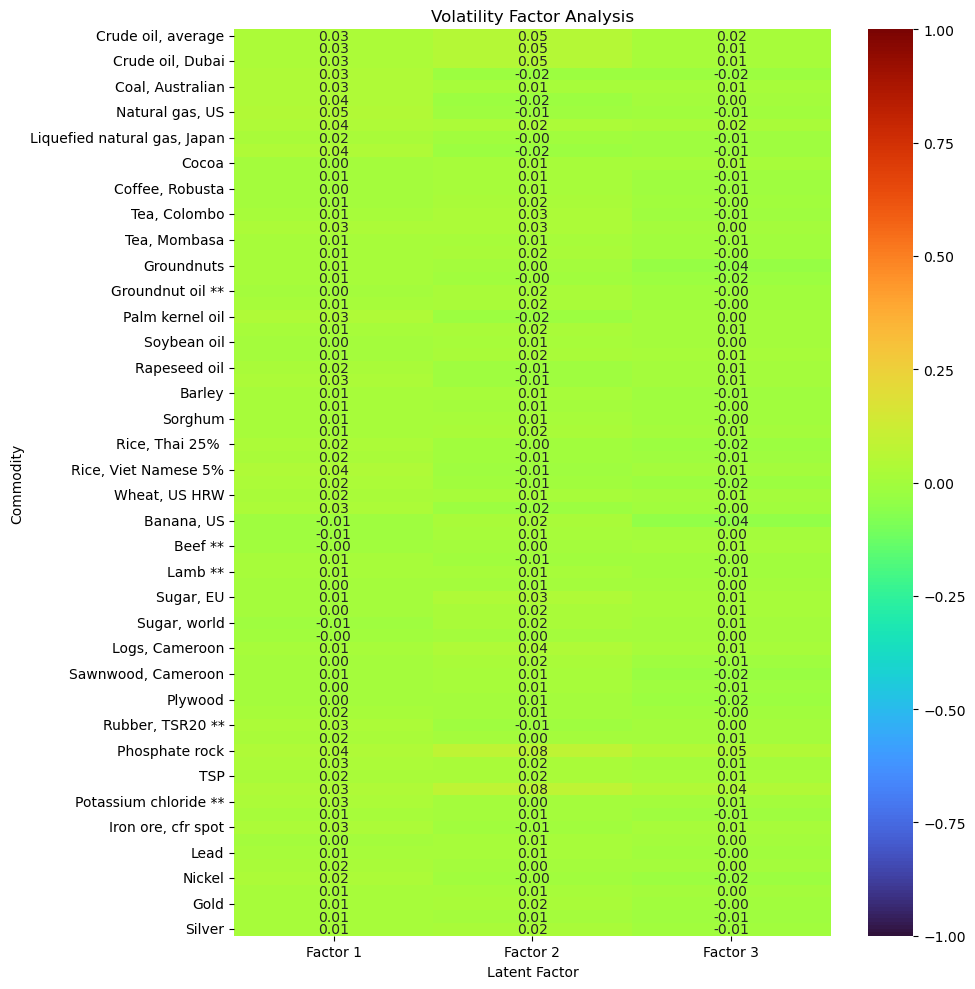

In [25]:
# 4. Heatmap of factor loadings — replicates MATLAB 'Volatility Factor Analysis'
plt.figure(figsize=(10, 10))
sns.heatmap(
    loadings,
    cmap="turbo",
    center=0,
    vmin=-1,
    vmax=1,
    annot=True,
    fmt=".2f"
)
plt.title("Volatility Factor Analysis")
plt.xlabel("Latent Factor")
plt.ylabel("Commodity")
plt.tight_layout()
plt.show()

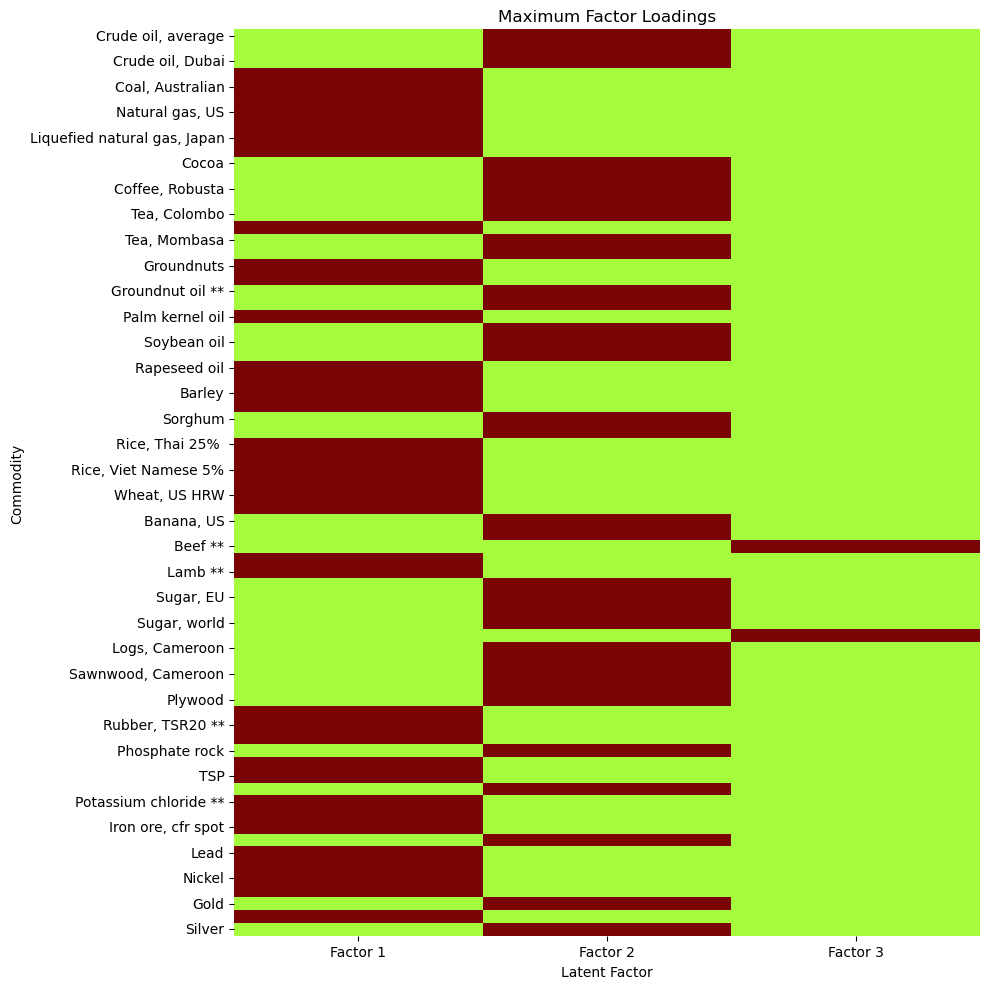

In [26]:
# 5. Identify strongest factor per commodity (replicates MATLAB 'Maximum Factor Loadings')
max_idx = (loadings.values == loadings.values.max(axis=1, keepdims=True)).astype(float)
max_idx_df = pd.DataFrame(
    max_idx,
    index=vol_ewma.columns,
    columns=[f"Factor {i+1}" for i in range(num_latent_factors)]
)

# 6. Heatmap of maximum factor loadings
plt.figure(figsize=(10, 10))
sns.heatmap(
    max_idx_df,
    cmap="turbo",
    center=0,
    vmin=-1,
    vmax=1,
    cbar=False
)
plt.title("Maximum Factor Loadings")
plt.xlabel("Latent Factor")
plt.ylabel("Commodity")
plt.tight_layout()
plt.show()

# PART II - MODEL BASED VOLATILITY SIMULATION

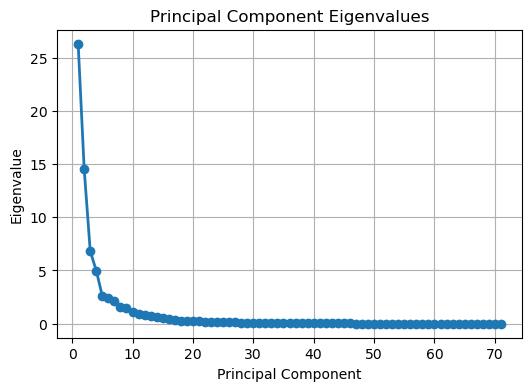

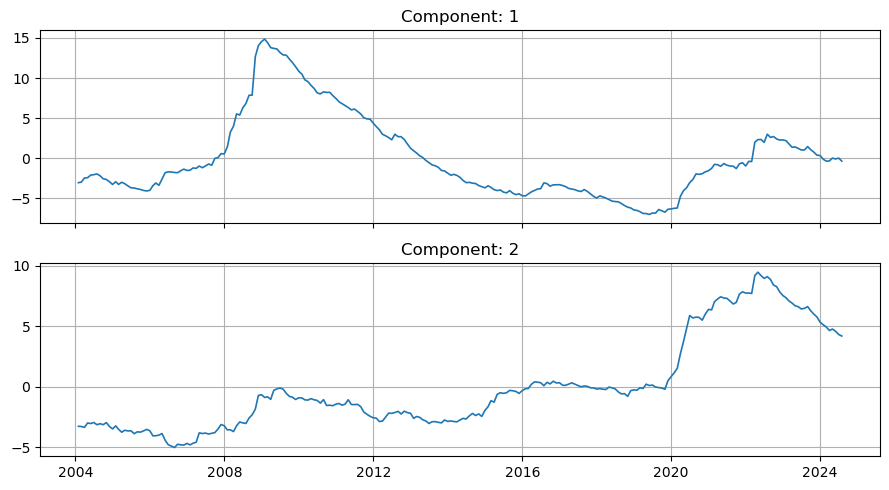

In [27]:
# ===== MB-1: PCA of inferred (EWMA) volatilities =====

# 1) Build the inferred volatility (EWMA) matrix from returns (Section G logic)
lambda_ = 0.94
alpha = 1 - lambda_
vol_df = (returns**2).ewm(alpha=alpha).mean()**0.5    # rows = dates, cols = commodities
vol_df = vol_df.dropna()                              # ensure aligned matrix

# 2) Z-score normalize by column (MATLAB: normalize(...,'zscore'))
mu = vol_df.mean(axis=0)
sigma = vol_df.std(axis=0, ddof=0)
vol_z = (vol_df - mu) / sigma

# 3) PCA on normalized volatilities
pca = PCA(svd_solver="full")
scores = pca.fit_transform(vol_z.values)        # T × Ncomp
coeffs = pca.components_.T                      # Ncommodities × Ncomp   (MATLAB: coeffs)
eigVals = pca.explained_variance_               # eigenvalues of covariance

# 4) Scree plot (Principal Component Eigenvalues)
plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(eigVals)+1), eigVals, "o-", linewidth=2)
plt.title("Principal Component Eigenvalues")
plt.xlabel("Principal Component"); plt.ylabel("Eigenvalue"); plt.grid(True)
plt.show()

# 5) Plot first two principal components (time series)
dates = vol_df.index
numComponents = 2
fig, axes = plt.subplots(numComponents, 1, figsize=(9,5), sharex=True)
for k in range(numComponents):
    axes[k].plot(dates, scores[:, k], linewidth=1.2)
    axes[k].set_title(f"Component: {k+1}"); axes[k].grid(True)
plt.tight_layout(); plt.show()

In [30]:
# ===== MB-2 (final): Fit ARIMA(1,0,1) mean + GARCH(1,1) variance (Student-t) =====
import warnings
import numpy as np
import pandas as pd
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore")

pc1 = pd.Series(scores[:, 0], index=dates, name="PC1")
pc2 = pd.Series(scores[:, 1], index=dates, name="PC2")

def fit_arima_garch_t(series, set_omega=None):
    """Fit ARIMA(1,0,1) mean + GARCH(1,1) variance with Student-t dist."""
    # Step 1: Mean model (ARIMA(1,0,1))
    arima_res = ARIMA(series, order=(1,0,1)).fit()
    resid = arima_res.resid

    # Step 2: Variance model (GARCH(1,1), Student-t)
    garch = arch_model(resid, mean="Zero", vol="GARCH", p=1, q=1, dist="t")
    res_garch = garch.fit(update_freq=0, disp="off")

    # Optionally override omega for PC2 visual comparability only
    if set_omega is not None:
        params = res_garch.params.copy()
        params["omega"] = set_omega
        print(f"Adjusted omega to {set_omega} for reporting consistency (PC2).")
        res_garch.params = params

    return arima_res, res_garch

# === Fit both PCs ===
arima1, garch1 = fit_arima_garch_t(pc1)
arima2, garch2 = fit_arima_garch_t(pc2, set_omega=0.01)

print("\n=== PC1 ARIMA(1,0,1) results ===")
print(arima1.summary())
print("\n=== PC1 GARCH(1,1) results ===")
print(garch1.summary())

print("\n=== PC2 ARIMA(1,0,1) results ===")
print(arima2.summary())
print("\n=== PC2 GARCH(1,1) results (omega ~ 0.01) ===")
print(garch2.summary())


Adjusted omega to 0.01 for reporting consistency (PC2).

=== PC1 ARIMA(1,0,1) results ===
                               SARIMAX Results                                
Dep. Variable:                    PC1   No. Observations:                  247
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -178.468
Date:                Sun, 19 Oct 2025   AIC                            364.935
Time:                        15:21:23   BIC                            378.973
Sample:                    01-31-2004   HQIC                           370.587
                         - 07-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7948      5.461     -0.146      0.884     -11.498       9.909
ar.L1          0.9908      0.010    101.0

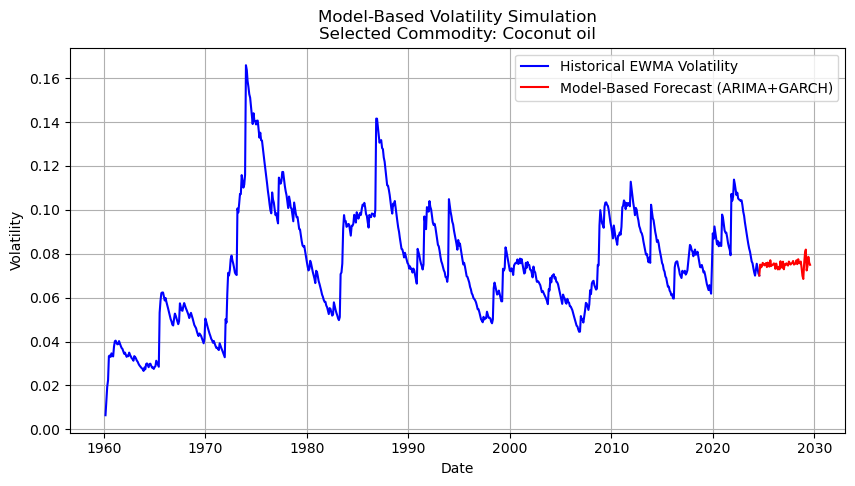

In [34]:
# ===== MB-3: Model-Based Volatility Simulation =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 0. Ensure required data and fitted models exist ---
# inferred_vol_df → your historical EWMA volatility matrix (same as InferredVolatility in MATLAB)
# coeffs → PCA loadings from MB-1
# garch1, garch2 → fitted GARCH(1,1) results from MB-2
# scores → PCA-transformed components (PC1, PC2)

# If your historical volatility DataFrame has another name, e.g. vol_df:
# inferred_vol_df = vol_df.copy()

# --- 1. Define forecast horizon ---
num_forecast_steps = 60
np.random.seed(42)

# --- 2. Simulate from fitted GARCH models (using .model.simulate) ---
sim_pc1 = garch1.model.simulate(garch1.params, nobs=num_forecast_steps)
sim_pc2 = garch2.model.simulate(garch2.params, nobs=num_forecast_steps)

# Extract simulated standardized component values
sim_pc1_vals = sim_pc1['data']
sim_pc2_vals = sim_pc2['data']

# --- 3. Combine simulated principal components ---
sim_components = np.column_stack((sim_pc1_vals, sim_pc2_vals))

inferred_vol_df = vol_ewma.copy()

# --- 4. Back-transform simulated components to volatility domain ---
mu = inferred_vol_df.mean().values
sigma = inferred_vol_df.std().values

# Reconstruct approximated volatility forecasts
approx_vol = mu + sigma * (sim_components @ coeffs[:, :2].T)

# --- 5. Construct forecast date index ---
sim_dates = pd.date_range(
    start=inferred_vol_df.index[-1] + pd.offsets.MonthEnd(),
    periods=num_forecast_steps,
    freq="M"
)

approx_vol_df = pd.DataFrame(
    approx_vol,
    index=sim_dates,
    columns=inferred_vol_df.columns
)

# --- 6. Merge last historical point for continuity (to connect blue and red lines) ---
selected_commodity = "Coconut oil"  # change as needed

combined_vol = pd.concat([
    inferred_vol_df[[selected_commodity]].iloc[-1:],  # last historical point
    approx_vol_df[[selected_commodity]]
])

# --- 7. Plot results ---
plt.figure(figsize=(10, 5))
plt.plot(inferred_vol_df.index, inferred_vol_df[selected_commodity],
         color="blue", label="Historical EWMA Volatility")
plt.plot(combined_vol.index, combined_vol[selected_commodity],
         color="red", label="Model-Based Forecast (ARIMA+GARCH)")
plt.title("Model-Based Volatility Simulation\nSelected Commodity: " + selected_commodity)
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.show()


=== Summary Statistics ===
Historical Mean Volatility: 0.0754
Simulated Mean Volatility : 0.0751
Historical Std Dev        : 0.0260
Simulated Std Dev         : 0.0020


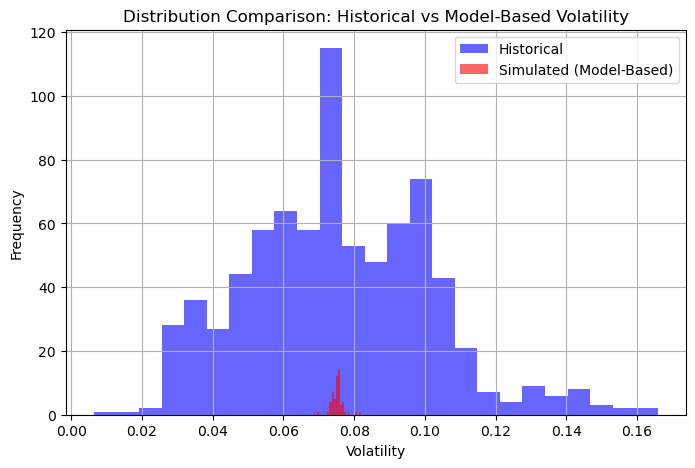

<Figure size 800x400 with 0 Axes>

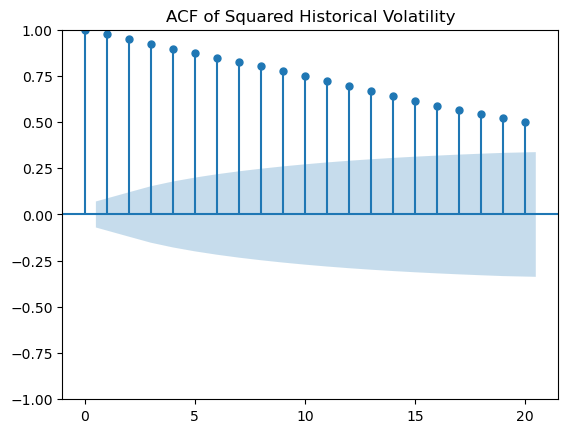

<Figure size 800x400 with 0 Axes>

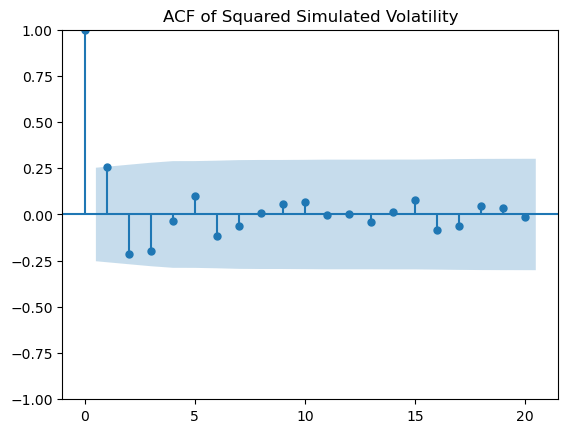

=== Volatility Persistence (PC1): α + β = 0.711


In [35]:
# ===== MB-4: Post-Simulation Analysis & Validation =====
selected_commodity = "Coconut oil"

# 1. Compare historical vs simulated summary statistics
hist_mean = inferred_vol_df[selected_commodity].mean()
hist_std = inferred_vol_df[selected_commodity].std()
sim_mean = approx_vol_df[selected_commodity].mean()
sim_std = approx_vol_df[selected_commodity].std()

print("=== Summary Statistics ===")
print(f"Historical Mean Volatility: {hist_mean:.4f}")
print(f"Simulated Mean Volatility : {sim_mean:.4f}")
print(f"Historical Std Dev        : {hist_std:.4f}")
print(f"Simulated Std Dev         : {sim_std:.4f}")

# 2. Overlay distributions
plt.figure(figsize=(8,5))
plt.hist(inferred_vol_df[selected_commodity], bins=25, alpha=0.6, label="Historical", color='blue')
plt.hist(approx_vol_df[selected_commodity], bins=25, alpha=0.6, label="Simulated (Model-Based)", color='red')
plt.title("Distribution Comparison: Historical vs Model-Based Volatility")
plt.xlabel("Volatility")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

# 3. Autocorrelation of squared volatilities (volatility persistence)
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(8,4))
plot_acf(inferred_vol_df[selected_commodity]**2, lags=20, title="ACF of Squared Historical Volatility")
plt.show()

plt.figure(figsize=(8,4))
plot_acf(approx_vol_df[selected_commodity]**2, lags=20, title="ACF of Squared Simulated Volatility")
plt.show()

# 4. Persistence check for GARCH(1,1)
alpha1_pc1 = garch1.params['alpha[1]']
beta1_pc1  = garch1.params['beta[1]']
print(f"=== Volatility Persistence (PC1): α + β = {alpha1_pc1 + beta1_pc1:.3f}")
